# Install packages

In [ ]:
# !pip install dataprep

In [ ]:
!pip install git+https://github.com/csebuetnlp/normalizer --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install pytorch-lightning==2.1.4 --quiet
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 20.8 MB/s eta 0:00:00


In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Using {device} device')

Using cuda device


In [ ]:
import subprocess
def get_gpu_name():
    try:
        output = subprocess.check_output(['nvidia-smi', '--query-gpu=name', '--format=csv,noheader'], encoding='utf-8')
        gpu_name = output.strip()
        return gpu_name
    except (subprocess.CalledProcessError, FileNotFoundError):
        return None
print(get_gpu_name())

Tesla T4


# Import and Mount

In [ ]:
import nltk
nltk.download("punkt")
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import transformers
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModelForPreTraining, AutoTokenizer
from normalizer import normalize
from transformers import AutoTokenizer, AutoModel
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [ ]:
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
#from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix


In [ ]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [ ]:
barishal_train_df = pd.read_csv("/content/drive/MyDrive/VASHANTOR/Train/Barishal Train Translation.csv")
ctg_train_df = pd.read_csv("/content/drive/MyDrive/VASHANTOR/Train/Chittagong Train Translation.csv")
mymensingh_train_df = pd.read_csv("/content/drive/MyDrive/VASHANTOR/Train/Mymensingh Train Translation.csv")
nohakhali_train_df = pd.read_csv("/content/drive/MyDrive/VASHANTOR/Train/Noakhali Train Translation.csv")
sylhet_train_df = pd.read_csv("/content/drive/MyDrive/VASHANTOR/Train/Sylhet Train Translation.csv")

In [ ]:
barishal_valid_df = pd.read_csv("/content/drive/MyDrive/VASHANTOR/Validation/Barishal  Validation Translation.csv")
ctg_valid_df = pd.read_csv("/content/drive/MyDrive/VASHANTOR/Validation/Chittagong Validation Translation.csv")
mymensingh_valid_df = pd.read_csv("/content/drive/MyDrive/VASHANTOR/Validation/Mymensingh Validation Translation.csv")
nohakhali_valid_df = pd.read_csv("/content/drive/MyDrive/VASHANTOR/Validation/Noakhali Validation Translation.csv")
sylhet_valid_df = pd.read_csv("/content/drive/MyDrive/VASHANTOR/Validation/Sylhet Validation Translation.csv")

In [ ]:
barishal_test_df = pd.read_csv("/content/drive/MyDrive/VASHANTOR/Test/Barishal Test Translation.csv")
ctg_test_df = pd.read_csv("/content/drive/MyDrive/VASHANTOR/Test/Chittagong Test Translation.csv")
mymensingh_test_df =  pd.read_csv("/content/drive/MyDrive/VASHANTOR/Test/Mymensingh Test Translation.csv")
nohakhali_test_df = pd.read_csv("/content/drive/MyDrive/VASHANTOR/Test/Noakhali Test Translation.csv")
sylhet_test_df = pd.read_csv("/content/drive/MyDrive/VASHANTOR/Test/Sylhet Test Translation.csv")

# Concate VASHANTOR DATASET (Train, valid, test)

In [ ]:
barishal_train_df = pd.concat([barishal_train_df, barishal_valid_df, barishal_test_df])
ctg_train_df = pd.concat([ctg_train_df, ctg_valid_df, ctg_test_df])
mymensingh_train_df = pd.concat([mymensingh_train_df, mymensingh_valid_df, mymensingh_test_df])
nohakhali_train_df = pd.concat([nohakhali_train_df, nohakhali_valid_df, nohakhali_test_df])
sylhet_train_df = pd.concat([sylhet_train_df, sylhet_valid_df, sylhet_test_df])

In [ ]:
barishal_train_df.head(5)

,bangla_speech,banglish_speech,barishal_bangla_speech,barishal_banglish_speech,region_name,english_speech
0,কেমন আছো ?,kemon acho?,আসো কোরোহম?,Aso korohom?,Barishal,How are you?
1,আজকে আমার মন ভালো নেই,ajke amr mon valo nei,আইজ মোর মনডা ভালোনা,aij mor monda valona,Barishal,I'm not feeling well today
2,তুমি কি করো ?,tumi ki koro?,ও মোনু হর কি?,o monu horo ki?,Barishal,what are you doing
3,এই গরমে আমার কিছু ভালো লাগে না,ei gorome amar kichu valo lage na,এই থাডা পরা গরমে মোর কিস্সু ভাল্লাগেনা,ei thada pora gorome mor kissu vallagena,Barishal,I don't like anything this summer
4,ছেলেটি সাদা রঙয়ের একটি শার্ট পরে এসেছিল,cheleti sada ronger ekti shirt pore eshechilo,পলাউগ্গা এউক্কা ধলা রং এর এউক্কা গুন্জি পইর্রা...,polaugga eukka dhola rong er eukka gunji poirr...,Barishal,The boy came wearing a white shirt


In [ ]:
barishal_train_df.columns

Index(['bangla_speech ', 'banglish_speech ', 'barishal_bangla_speech ',
       'barishal_banglish_speech ', 'region_name ', 'english_speech'],
      dtype='object')

In [ ]:
ctg_train_df.columns

Index(['bangla_speech ', 'banglish_speech ', 'chittagong_bangla_speech ',
       'chittagong_banglish_speech ', 'region_name ', 'english_speech'],
      dtype='object')

In [ ]:
mymensingh_train_df.columns

Index(['bangla_speech ', 'banglish_speech ', 'mymensingh_bangla_speech ',
       'mymensingh_banglish_speech ', 'region_name ', 'english_speech'],
      dtype='object')

In [ ]:
nohakhali_train_df.columns

Index(['bangla_speech ', 'banglish_speech ', 'noakhali_bangla_speech ',
       'noakhali_banglish_speech ', 'region_name ', 'english_speech'],
      dtype='object')

In [ ]:
sylhet_train_df.columns

Index(['bangla_speech ', 'banglish_speech ', 'sylhet_bangla_speech ',
       'sylhet_banglish_speech ', 'region_name ', 'english_speech'],
      dtype='object')

# Drop Columns

In [ ]:
barishal_train_df.drop(columns=['banglish_speech ', 'barishal_bangla_speech ', 'english_speech'], inplace=True)
ctg_train_df.drop(columns=['banglish_speech ', 'chittagong_bangla_speech ', 'english_speech'], inplace=True)
mymensingh_train_df.drop(columns=['banglish_speech ', 'mymensingh_bangla_speech ', 'english_speech'], inplace=True)
nohakhali_train_df.drop(columns=['banglish_speech ', 'noakhali_bangla_speech ', 'english_speech'], inplace=True)
sylhet_train_df.drop(columns=['banglish_speech ', 'sylhet_bangla_speech ', 'english_speech'], inplace=True)


# Rename Columns from xyz_bangla_speech to regional_text

In [ ]:
barishal_train_df.rename(columns={'barishal_banglish_speech ': 'regional_text'}, inplace=True)
ctg_train_df.rename(columns={'chittagong_banglish_speech ': 'regional_text'}, inplace=True)
mymensingh_train_df.rename(columns={'mymensingh_banglish_speech ': 'regional_text'}, inplace=True)
nohakhali_train_df.rename(columns={'noakhali_banglish_speech ': 'regional_text'}, inplace=True)
sylhet_train_df.rename(columns={'sylhet_banglish_speech ': 'regional_text'}, inplace=True)

In [ ]:
sylhet_train_df.columns

Index(['bangla_speech ', 'regional_text', 'region_name '], dtype='object')

In [ ]:
sylhet_train_df['region_name '].unique()

array(['Sylhet', 'Sylhet '], dtype=object)

In [ ]:
sylhet_train_df['region_name '] = sylhet_train_df['region_name '].replace('Sylhet ', 'Sylhet')


In [ ]:
sylhet_train_df['region_name '].unique()

array(['Sylhet'], dtype=object)

# Concate all regional text

In [ ]:
df = pd.concat([barishal_train_df, ctg_train_df, mymensingh_train_df, nohakhali_train_df, sylhet_train_df])

In [ ]:
# df = df.head(7000)

In [ ]:
df.tail(500)

,bangla_speech,regional_text,region_name
125,সে সবসময় মিথ্যা কথা বলতো,he hokhol somoy micha mat matto,Sylhet
126,সবাই তাকে অনেক ভয় পেতো,hokhole tare khub doraito,Sylhet
127,কেউ তাকে ভালোবাসতো নাহ,keu tare bala paito na,Sylhet
128,সে খুবই খারাপ ছিল,he bout bad achilo,Sylhet
129,গ্রামের মানুষরা ছেলেটির থেকে দূরে থাকতে চেষ্টা...,gram or mainshe fuya ogur tone dure thakar che...,Sylhet
...,...,...,...
370,তুমি কি আমাকে এক গ্লাস পানি এনে দিতে পারবে ?,tumi ki amare ek glass fani ene ditay farba?,Sylhet
371,আমি পারবো না পানি দিতে,ami parbo na fani dite,Sylhet
372,তোমার ভাই পড়ালেখাতে অনেক মেধাবি,tomar vai foralekhate bohut medhabi,Sylhet
373,আচ্ছা বলো দেখি বাংলাদেশে কয়টি জেলা?,aiccha kow dekhi bangladesho koyta jela?,Sylhet


# Encode region_name column

In [ ]:
df.columns

Index(['bangla_speech ', 'regional_text', 'region_name '], dtype='object')

In [ ]:
df.rename(columns={'bangla_speech ': 'bangla_speech'}, inplace=True)
df.rename(columns={'region_name ': 'region_name'}, inplace=True)

In [ ]:
label_encoder = LabelEncoder()

df['region_encoded'] = label_encoder.fit_transform(df['region_name'])

In [ ]:
df['region_name'].unique()

array(['Barishal ', 'Chittagong', 'Mymensingh', 'Noakhali', 'Sylhet'],
      dtype=object)

In [ ]:
df['region_encoded'].unique()

array([0, 1, 2, 3, 4])

In [ ]:
# df.drop(columns=['region_name '], inplace=True)

In [ ]:
# df.columns

In [ ]:
# df.to_csv('/content/drive/MyDrive/On going Research/VASHANTOR/combined_regional_text.csv', index=False)

# Dataset Normalize

**Remove Puntuation**

In [ ]:
def remove_punctuations(text):
  whitespace = re.compile(u"[\s\u0020\u00a0\u1680\u180e\u202f\u205f\u3000\u2000-\u200d]+", re.UNICODE)
  bangla_fullstop = u"\u0964"
  text = re.sub(r'(^|\s)@(\w+)', r'\1@user', text)
  text = re.sub(r'\bhttp?s://\S+\b', '', text)
  punctSeq = u"['\"“”‘’]+|[.?!,…]+|[:;]+"
  punc = u"[(),$%^&*+={}\[\]:\"\৷|\'\~`<>/,¦!?½£¶¼©⅐⅑⅒⅓⅔⅕⅖⅗⅘⅙⅚⅛⅜⅝⅞⅟↉¤¿º;-]+"
  text = whitespace.sub(" ", text).strip()
  text = re.sub(punctSeq, " ", text)
  text = re.sub(bangla_fullstop, " ", text)
  text = re.sub(punc, " ", text)
  text = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~]', ' ', text)
  result = re.sub(r'\b[a-zA-Z]+\b', '', text)
  text=text.replace("\\", " ")
  normalized = normalize(text)
  return text


In [ ]:
df['bangla_speech'] = df['bangla_speech'].apply(remove_punctuations)
df['regional_text'] = df['regional_text'].apply(remove_punctuations)

# Analysis Data

In [ ]:
df.head(10)

,bangla_speech,regional_text,region_name,region_encoded
0,কেমন আছো,Aso korohom,Barishal,0
1,আজকে আমার মন ভালো নেই,aij mor monda valona,Barishal,0
2,তুমি কি করো,o monu horo ki,Barishal,0
3,এই গরমে আমার কিছু ভালো লাগে না,ei thada pora gorome mor kissu vallagena,Barishal,0
4,ছেলেটি সাদা রঙয়ের একটি শার্ট পরে এসেছিল,polaugga eukka dhola rong er eukka gunji poirr...,Barishal,0
5,মেয়েটি লাল রঙয়ের শাড়ি পরে আমার সাথে দেখা করতে ...,maiaugga lal runga shari poirra mor loge deha ...,Barishal,0
6,ছেলেটি সিলেট থেকে ঢাকায় এসেছে,polaugga sylhet dia dhaha aisele,Barishal,0
7,মেয়েটি সিলেট থেকে আসা এই ছেলেটিকে অনেক ভালবাসে,maiaugga sylhet dia awa polauggare akser valopay,Barishal,0
8,ছেলেটি মেয়েটাকে এখনো ভালবাসার চোখে দেখেনি,polaugga maiauggare ahono valopawar chohe dehenai,Barishal,0
9,মেয়েটি তাঁর সব স্বপ্নের মধ্যে ছেলেটাকে কল্পনা করে,maiaugga heyar shob hopponer moiddhe polauggar...,Barishal,0


**Remove Stopwords**

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('bengali'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def stop_words_remover(text):
    words = word_tokenize(text)

    without_stop_words = [word for word in words if word not in stop_words]

    without_stop_word_text = ' '.join(without_stop_words)

    return without_stop_word_text


In [ ]:
df['bangla_speech'] = df['bangla_speech'].apply(stop_words_remover)
df['regional_text'] = df['regional_text'].apply(stop_words_remover)

In [ ]:
df.head(10)

,bangla_speech,regional_text,region_name,region_encoded
0,কেমন আছো,Aso korohom,Barishal,0
1,আজকে মন ভালো,aij mor monda valona,Barishal,0
2,করো,o monu horo ki,Barishal,0
3,গরমে ভালো লাগে,ei thada pora gorome mor kissu vallagena,Barishal,0
4,ছেলেটি সাদা রঙয়ের শার্ট এসেছিল,polaugga eukka dhola rong er eukka gunji poirr...,Barishal,0
5,মেয়েটি লাল রঙয়ের শাড়ি সাথে এসেছিল,maiaugga lal runga shari poirra mor loge deha ...,Barishal,0
6,ছেলেটি সিলেট ঢাকায় এসেছে,polaugga sylhet dia dhaha aisele,Barishal,0
7,মেয়েটি সিলেট আসা ছেলেটিকে ভালবাসে,maiaugga sylhet dia awa polauggare akser valopay,Barishal,0
8,ছেলেটি মেয়েটাকে এখনো ভালবাসার চোখে দেখেনি,polaugga maiauggare ahono valopawar chohe dehenai,Barishal,0
9,মেয়েটি স্বপ্নের ছেলেটাকে কল্পনা,maiaugga heyar shob hopponer moiddhe polauggar...,Barishal,0


In [ ]:
df.shape

(12500, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12500 entries, 0 to 374
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   bangla_speech   12500 non-null  object
 1   regional_text   12500 non-null  object
 2   region_name     12500 non-null  object
 3   region_encoded  12500 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 488.3+ KB


In [ ]:
df['region_name'].value_counts()

Barishal      2500
Chittagong    2500
Mymensingh    2500
Noakhali      2500
Sylhet        2500
Name: region_name, dtype: int64

In [ ]:
df.isna().sum()

bangla_speech     0
regional_text     0
region_name       0
region_encoded    0
dtype: int64

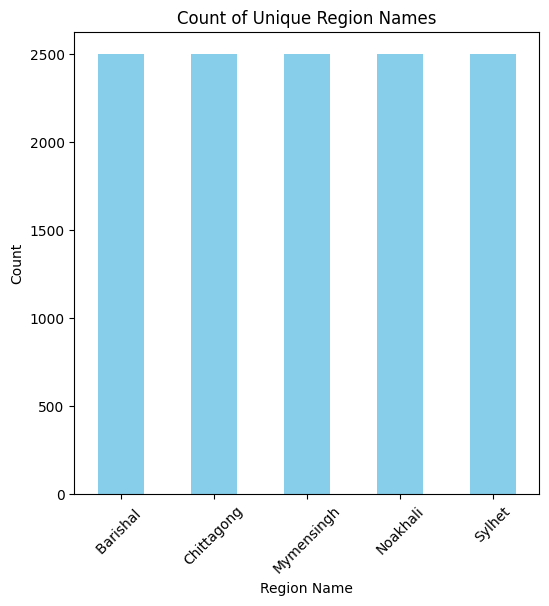

In [ ]:
unique_regions = df['region_name'].value_counts()
plt.figure(figsize=(6, 6))
unique_regions.plot(kind='bar', color='skyblue')
plt.title('Count of Unique Region Names')
plt.xlabel('Region Name')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


# To implement model

In [ ]:
df.rename(columns={'regional_text': 'Data'}, inplace=True)
df.rename(columns={'region_encoded': 'Label'}, inplace=True)

In [ ]:
df.head(1)

,bangla_speech,Data,region_name,Label
0,কেমন আছো,Aso korohom,Barishal,0


In [ ]:
class_names = ['Barishal', 'Chittagong','Mymensingh','Noakhali','Sylhet']

In [ ]:
df

,bangla_speech,Data,region_name,Label
0,কেমন আছো,Aso korohom,Barishal,0
1,আজকে মন ভালো,aij mor monda valona,Barishal,0
2,করো,o monu horo ki,Barishal,0
3,গরমে ভালো লাগে,ei thada pora gorome mor kissu vallagena,Barishal,0
4,ছেলেটি সাদা রঙয়ের শার্ট এসেছিল,polaugga eukka dhola rong er eukka gunji poirr...,Barishal,0
...,...,...,...,...
370,এক গ্লাস পানি এনে পারবে,tumi ki amare ek glass fani ene ditay farba,Sylhet,4
371,পারবো পানি,ami parbo na fani dite,Sylhet,4
372,ভাই পড়ালেখাতে মেধাবি,tomar vai foralekhate bohut medhabi,Sylhet,4
373,আচ্ছা বলো দেখি বাংলাদেশে কয়টি জেলা,aiccha kow dekhi bangladesho koyta jela,Sylhet,4


# Train-Valid-Test

In [ ]:
from sklearn.model_selection import train_test_split


X = df.drop(columns=['Label','bangla_speech','region_name'])
y = df['Label']

df_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)
df_test, df_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Print the sizes of the resulting datasets
print("Training set size:", len(df_train))
print("Testing set size:", len(df_test))
print("Validation set size:", len(df_val))


Training set size: 9375
Testing set size: 2500
Validation set size: 625


In [ ]:
df_train = pd.concat([df_train, y_train], axis=1)
df_test = pd.concat([df_test, y_test], axis=1)
df_val = pd.concat([df_val, y_val], axis=1)

# Tokenizer bert

In [ ]:
model_name = "csebuetnlp/banglishbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/874 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/366k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
MAX_LEN = 128

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, comments, targets, tokenizer, max_len):
    self.comments = comments
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.comments)
  def __getitem__(self, item):
    review = str(self.comments[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'Data': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((9375, 2), (625, 2), (2500, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    comments=df.Data.to_numpy(),
    targets=df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,

  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
data = next(iter(train_data_loader))
data.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest s

dict_keys(['Data', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


In [ ]:
bert_model = AutoModelForPreTraining.from_pretrained(model_name)

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [ ]:
class sentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(sentimentClassifier, self).__init__()
        self.electra = AutoModelForPreTraining.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(128, n_classes)  # Adjust the input size

    def forward(self, input_ids, attention_mask):
        outputs = self.electra(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        pooled_output = outputs.logits  # Access logits for pooled output
        output = self.drop(pooled_output)
        return self.out(output)


In [ ]:
model = sentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape)

torch.Size([16, 128])
torch.Size([16, 128])


In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=True)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=4,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from tqdm import tqdm
import torch.nn as nn
import numpy as np

def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  #tqdm for progress monitoring
  data_loader = tqdm(data_loader, desc="Training", unit="batch")

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    data_loader.set_postfix(loss=np.mean(losses))

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
from tqdm import tqdm
import torch
import numpy as np

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0


    data_loader = tqdm(data_loader, desc="Evaluating", unit="batch")

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            # Update tqdm description with the current loss
            data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'\nTrain loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'\nVal   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


Training:   0%|          | 0/586 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `ma


Train loss 1.1956365305815948 accuracy 0.4944


Evaluating:   0%|          | 0/40 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding


Val   loss 0.6407181642949581 accuracy 0.7344

Epoch 2/10
----------


Training:   0%|          | 0/586 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=


Train loss 0.5896261773444077 accuracy 0.7773866666666667


Evaluating:   0%|          | 0/40 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 0.4289192530006403 accuracy 0.8384

Epoch 3/10
----------


Training:   0%|          | 0/586 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.38024092143013716 accuracy 0.8623999999999999


Evaluating:   0%|          | 0/40 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `m


Val   loss 0.44620263106189667 accuracy 0.872

Epoch 4/10
----------


Training:   0%|          | 0/586 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.2764106050754322 accuracy 0.9024


Evaluating:   0%|          | 0/40 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `m


Val   loss 0.501831952820794 accuracy 0.8576

Epoch 5/10
----------


Training:   0%|          | 0/586 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.2167553363999955 accuracy 0.9265066666666667


Evaluating:   0%|          | 0/40 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding


Val   loss 0.545143972901856 accuracy 0.8768

Epoch 6/10
----------


Training:   0%|          | 0/586 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.15518988066327774 accuracy 0.9496533333333333


Evaluating:   0%|          | 0/40 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 0.7234292186780976 accuracy 0.8768

Epoch 7/10
----------


Training:   0%|          | 0/586 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.12150528620811159 accuracy 0.9642666666666667


Evaluating:   0%|          | 0/40 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 1.024265601675824 accuracy 0.872

Epoch 8/10
----------


Training:   0%|          | 0/586 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.09986001394685315 accuracy 0.97408


Evaluating:   0%|          | 0/40 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncati


Val   loss 1.2927536600439737 accuracy 0.8672000000000001

Epoch 9/10
----------


Training:   0%|          | 0/586 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=


Train loss 0.0793122525046541 accuracy 0.9800533333333333


Evaluating:   0%|          | 0/40 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding


Val   loss 1.3663458278868348 accuracy 0.8768

Epoch 10/10
----------


Training:   0%|          | 0/586 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.056014045695786295 accuracy 0.9847466666666667


Evaluating:   0%|          | 0/40 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding


Val   loss 1.3877383087296038 accuracy 0.8736

CPU times: user 22min 51s, sys: 10min 20s, total: 33min 11s
Wall time: 34min 17s


In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Evaluating:   0%|          | 0/157 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `paddin

0.882

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  toxic_comments = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["Data"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      toxic_comments.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return toxic_comments, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names,digits=4))


              precision    recall  f1-score   support

    Barishal     0.8975    0.9080    0.9027       511
  Chittagong     0.9528    0.9098    0.9308       488
  Mymensingh     0.8430    0.8480    0.8455       513
    Noakhali     0.8646    0.8543    0.8594       501
      Sylhet     0.8577    0.8912    0.8741       487

    accuracy                         0.8820      2500
   macro avg     0.8831    0.8823    0.8825      2500
weighted avg     0.8828    0.8820    0.8822      2500



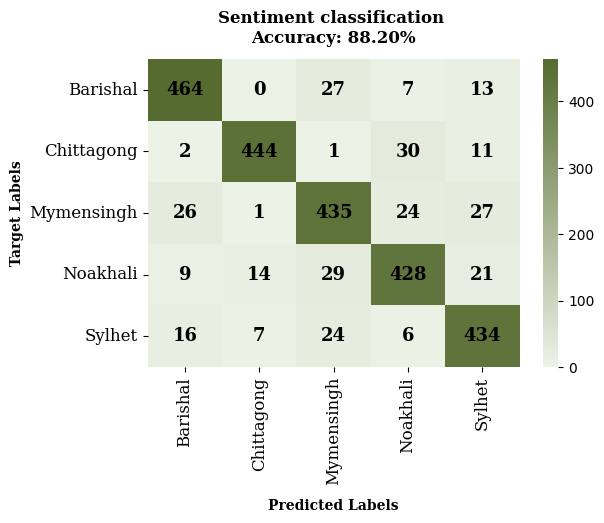

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy_percentage = accuracy * 100

# Plot confusion matrix
plt.figure(figsize=(6, 4))
# Define the custom palette
custom_palette = sns.light_palette("DarkOliveGreen", as_cmap=True)
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
font2 = {'family': 'Serif', 'weight': 'bold', 'size': 10}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,
                      xticklabels=class_names, yticklabels=class_names,
                      annot_kws={"family": "Serif", 'color':'black','weight': 'bold', 'size': 13})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font2)
heatmap.set_ylabel('Target Labels', fontdict=font2)
heatmap.set_title('Sentiment classification \nAccuracy: {:.2f}%'.format(accuracy_percentage),
                  fontdict=font, pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space


plt.show()